**Цель задания**: Предсказать цены каждого дома, что будет представлен к анализу.  
Необходимо проанализировать тестовые наборы данных и на основе анализа выполнить предсказание новых наборов данных.

### Importing libraries.

Для анализа буду использовать стандартные библиотеки работы с данными, а так же библиотеки для построения графиков.

In [2]:
# Importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats

# Reduce the level of the axis logger to error:
# !!! Уберает все ненужные предупреждения, кроме ошибок.
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

### Reading the data.

In [3]:
# Impoirting the dataset
house_prices_dataset_path = "./data/house-prices-advanced-regression-techniques/sample_submission.csv"
house_prices_test_path = "./data/house-prices-advanced-regression-techniques/test.csv"
house_prices_train_path = "./data/house-prices-advanced-regression-techniques/train.csv"
house_data_discription_path = "./data/house-prices-advanced-regression-techniques/data_description.txt"

house_prices = pd.read_csv(house_prices_dataset_path)
house_prices_test = pd.read_csv(house_prices_test_path)
house_prices_train = pd.read_csv(house_prices_test_path)

### Review Data (Understanding the Data)
#### First things first: analysing 'SalePrice'

Важной нитью всего анализа является понять тот факт, что представляет из себя цена. Иными словами необходимо разобраться в том:  
        - какие стеки данных формируют цену.  
        - какие стеки данных и насколько сильно влияют на изменение цены(величина корреляции данных и цены).  
        - в каком колличестве представленые стеки данных влияют на изменение цены.  
        - есть ли пропущенные значения среди этих стеков.  
        - насколько важно влияние на цену факта заполнения пропусков в стеках.  
        - насколько важно влияние на цену факта удаления строк где есть пустые значения.  

Для начала я хочу применить немного описательной статистики и визуально осмотреть данные с ценами.  
Тут видно, что всего в стеке содержится 1459 значений.  
Средняя цена представленная за дом в данном (не обработанном) стеке данных равна ~179184.  
Стандартное отклонение составляет ~16518. Оно показывает насколько в среднем цены на зданий отличаются от средней их стоимости.  
Также представлены минимальная и максимальная цены в данном стеке.
Квартили же полезны тем, что с их помощью возможно увидеть как распределены данные по четвертям. Иными словами, первые 25% стека содержат среднюю цену 168703, вторые 25% 179209, а третья часть 186789, а так-же минимальная цена 135751 и максимальная равна 281644. Такое разделение позволяет объективно оценить к примеру то, что максимальная часть сильно выбивается из общей массы данных, так-же видно что шаг между квартилями не имеет большую величину, а если разброс данных невелик, то разница между богатыми и средне-обеспеченными кварталами данной области не имеет большой разницы, что говорит о комфортном сосуществовании обееих прослоек населения. 

*Что-же это было лишь поверхностное наблюдение, теперь стоит углубиться в более детальный разбор данных.*

In [8]:
# descriptive statistics summary
house_prices['SalePrice'].describe()

count      1459.000000
mean     179183.918243
std       16518.303051
min      135751.318893
25%      168703.011202
50%      179208.665698
75%      186789.409363
max      281643.976117
Name: SalePrice, dtype: float64

Для начала я решил объеденить наборы данных для более удобного изучения.

Я решил, что было бы правильным представить себе как выглядят данные в наборе, какие стеки в нем представлены, а так-же их тип и что важно я решил глянуть насколько сильны-полноценны стеки данного датасета.

In [9]:
# Understanding the data component
house_prices['SalePrice'] = house_prices['SalePrice'].astype('int64')
full_dataset = pd.concat([house_prices_test, house_prices.drop(columns='Id')], axis=1)
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

Что же бегло просмотрев полученную статистику, можно увидеть как внутри некоторых колонок нехватает данных, тоесть они банально отсутствуют, что теперь важно так это понять насколько важно их отсутствие, как сильно оно может повлиять на дальнейшее прогнозирование еще не поступивших(новых) данных.

Заодно полезным-не очень:) я посчитал оценить какие типы данных и в каких пропорциях(в процентах) составляют данный датасет.

In [10]:
# Check possible values and frequency for each individual value in a DF
full_dataset.dtypes.value_counts(normalize = True)

object     0.530864
int64      0.333333
float64    0.135802
dtype: float64

Продолжаем исследовать факторы, что все же приведут нас к ответу, что же все-таки есть цена?

Немаловажным является так-же и то, что визуализация данных это весомый метод оценки данных, так как он более воспреимчив человеком чем цифро-буквенный.  
На данной гисторгамме можно увидеть, как распределяются цены в 

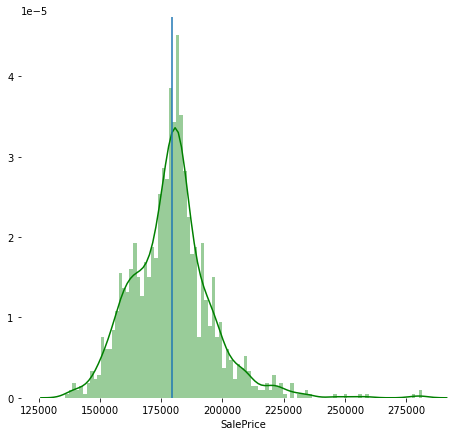

In [13]:
# histogram
f, ax = plt.subplots(figsize=(8, 7))
graph = sns.distplot(house_prices['SalePrice'], bins=int(100), color = 'green')
graph.axvline(house_prices['SalePrice'].mean())
graph = sns.despine(trim=True, left=True, bottom=True)

plt.show()

In [14]:
# Skewness and Kurtosis
print(f"Skewness: {house_prices['SalePrice'].skew()}")
print(f"Kurtosis: {house_prices['SalePrice'].kurt()}")

Skewness: 0.9293607278733801
Kurtosis: 3.794725725561073


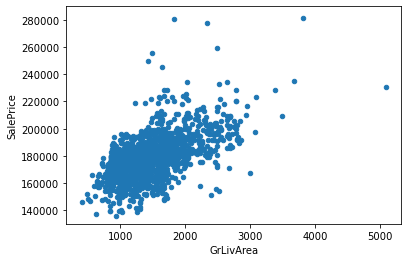

In [15]:
# scatter plot `grlivarea/saleprice`
# GrLivArea: Above grade (ground) living area square feet
var = 'GrLivArea'
data = pd.concat([house_prices['SalePrice'], house_prices_test[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(130000,290000));

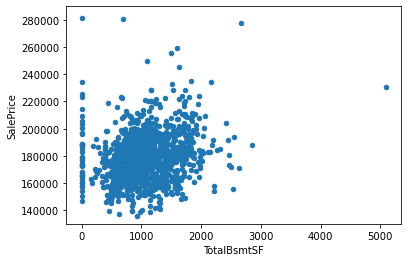

In [16]:
# scatter plot totalbsmtsf/saleprice
# TotalBsmtSF: Total square feet of basement area
var = 'TotalBsmtSF'
data = pd.concat([house_prices['SalePrice'], house_prices_test[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(130000,290000));

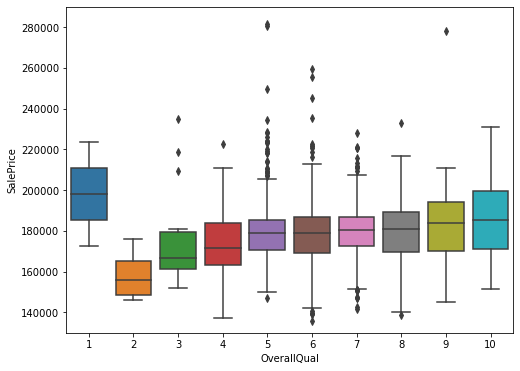

In [17]:
# box plot overallqual/saleprice
# OverallQual: Rates the overall material and finish of the house
#        10	Very Excellent
#        9	Excellent
#        8	Very Good
#        7	Good
#        6	Above Average
#        5	Average
#        4	Below Average
#        3	Fair
#        2	Poor
#        1	Very Poor

var = 'OverallQual'
data = pd.concat([house_prices['SalePrice'], house_prices_test[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))

fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=130000, ymax=290000);

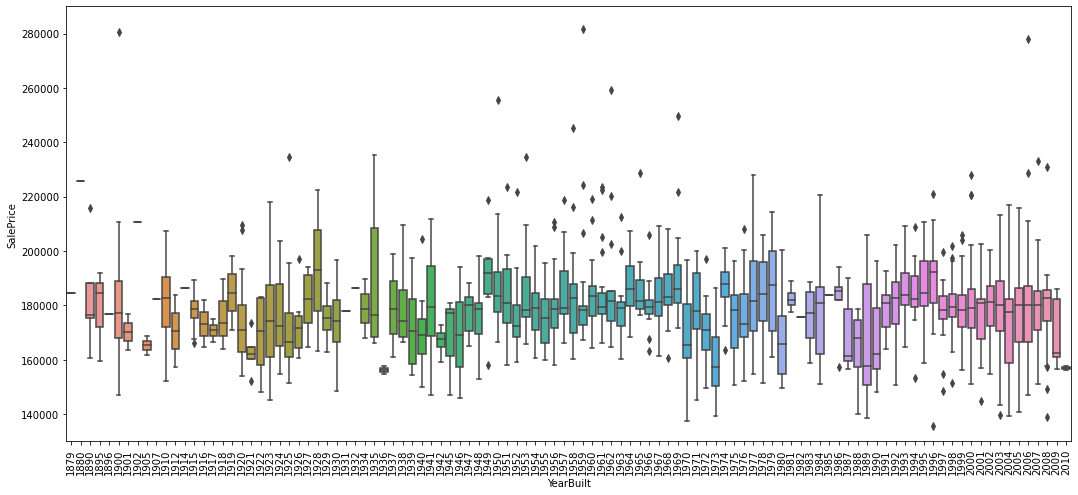

In [18]:
# box plot YearBuilt/saleprice
# YearBuilt: Original construction date
var = 'YearBuilt'
data = pd.concat([house_prices['SalePrice'], house_prices_test[var]], axis=1)

f, ax = plt.subplots(figsize=(18, 8))

fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=130000, ymax=290000);
plt.xticks(rotation=90);

### Keep calm and work smart
#### Correlation matrix (heatmap style)
>A ***heatmap*** is a graphical representation of data in which data values are represented as colors.  
That is, it uses color in order to communicate a value to the reader.  
This is a great tool to assist the audience towards the areas that matter the most when you have a large volume of data.

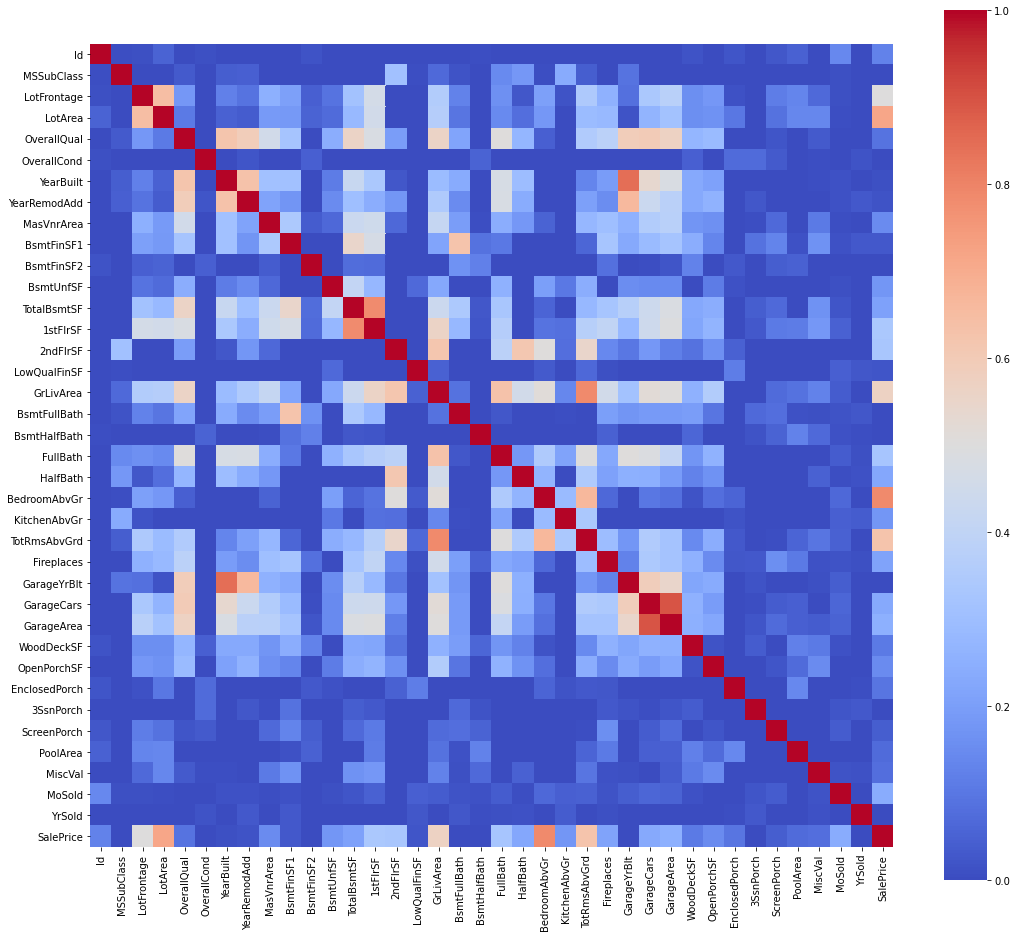

In [19]:
# correlation matrix for `full_dataset`
corrmat = full_dataset.corr()
matrix = np.tril(full_dataset.corr())
f, ax = plt.subplots(figsize=(18,16))
sns.heatmap(corrmat, vmin=0, vmax=1, square=True, cmap= 'coolwarm');

['SalePrice', 'BedroomAbvGr', 'LotArea', 'TotRmsAbvGrd', 'GrLivArea', 'LotFrontage', '1stFlrSF', '2ndFlrSF', 'FullBath', 'GarageArea']


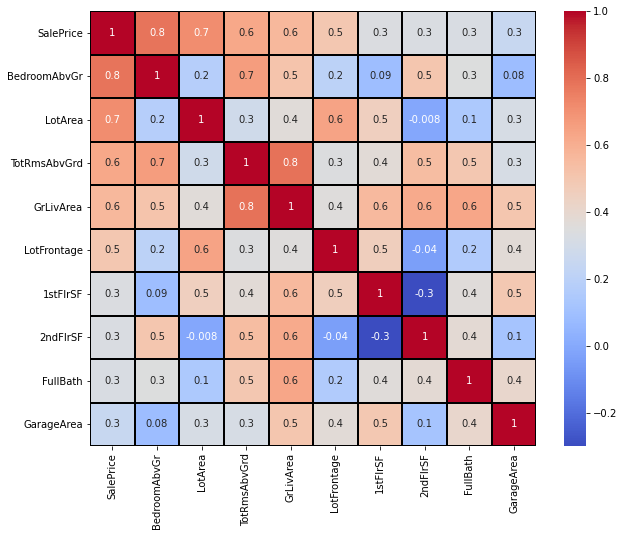

In [20]:
# saleprice correlation matrix
k = 10
# Ten best variables correlation with 'SalePrice'
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index

corrmat = full_dataset[cols].corr()
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corrmat, annot=True, fmt='.1g', cmap='coolwarm', linewidths=1, linecolor='black');

print(list(cols))

In [21]:
full_dataset[cols].isnull().sum()

SalePrice         0
BedroomAbvGr      0
LotArea           0
TotRmsAbvGrd      0
GrLivArea         0
LotFrontage     227
1stFlrSF          0
2ndFlrSF          0
FullBath          0
GarageArea        1
dtype: int64

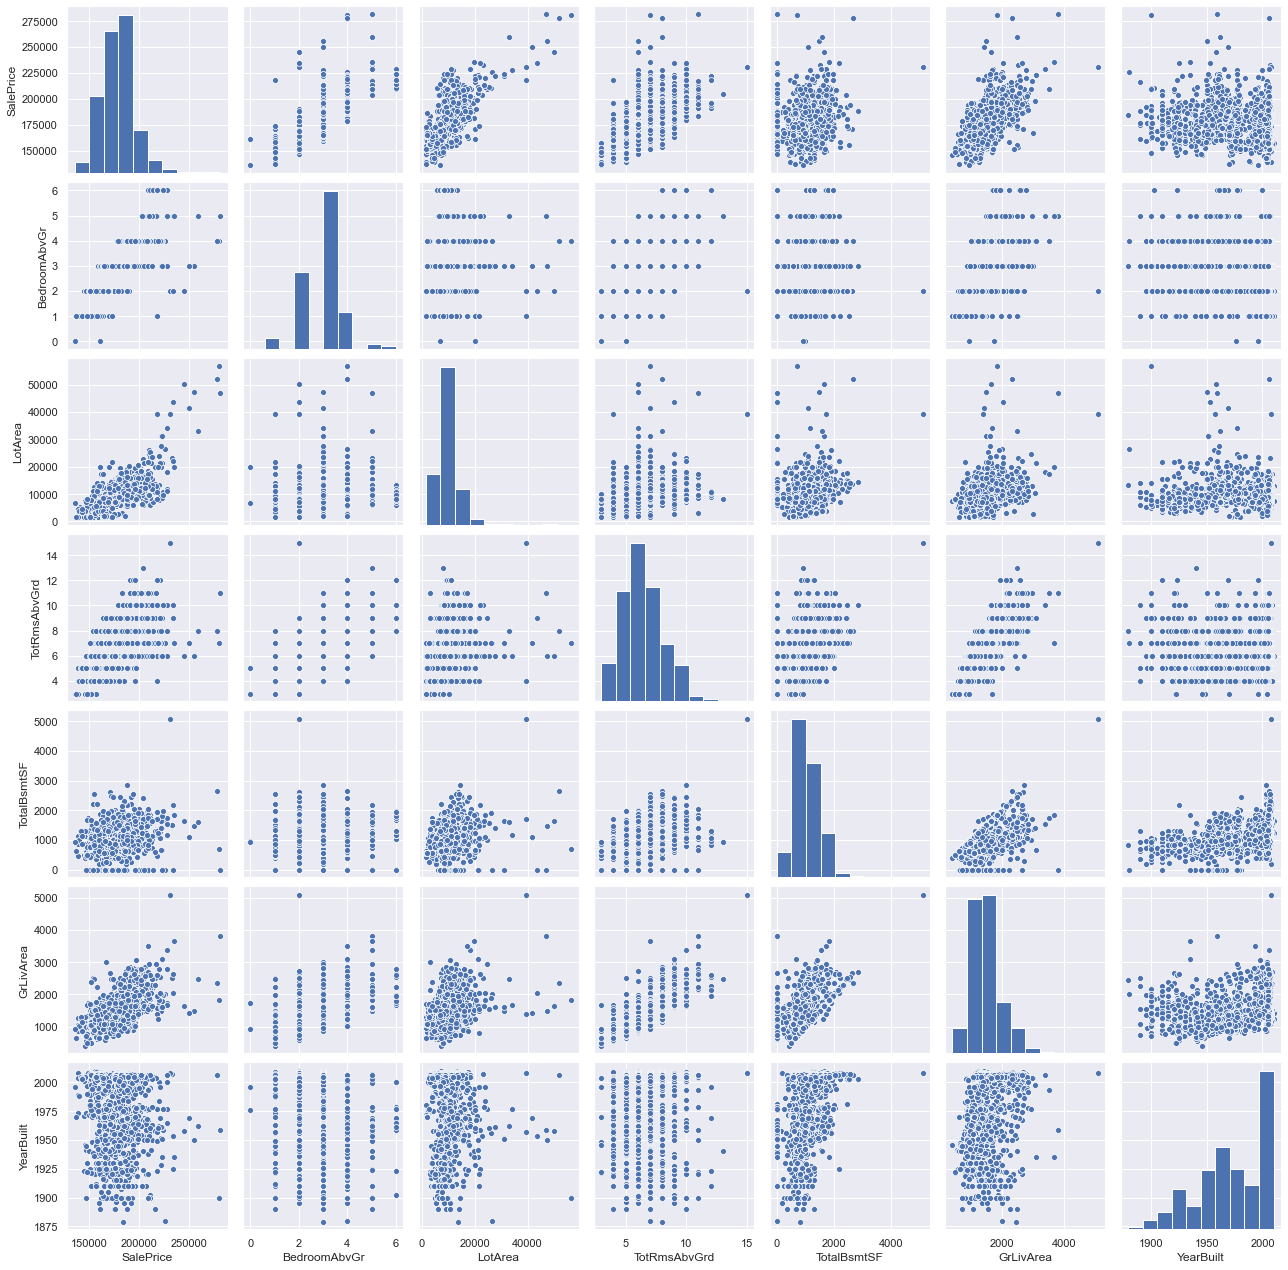

In [22]:
# scatterplot
sns.set()
cols = ['SalePrice', 'BedroomAbvGr', 'LotArea', 'TotRmsAbvGrd', 'TotalBsmtSF',  'GrLivArea', 'YearBuilt']
sns.pairplot(full_dataset[cols], height=2.5);
plt.show();

### Missing data
Important questions when thinking about missing data:

How prevalent is the missing data?
Is missing data random or does it have a pattern?

In [23]:
total = full_dataset.isnull().sum().sort_values(ascending=False)
percent = (full_dataset.isnull().sum()/full_dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total[total>0], percent[percent>0]], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageFinish,78,0.053461
GarageYrBlt,78,0.053461
GarageCond,78,0.053461
GarageQual,78,0.053461


In [24]:
# removing missing variables and individual values
full_dataset = full_dataset.drop((missing_data[missing_data['Total']>1]).index, 1)
full_dataset = full_dataset.dropna()
full_dataset.shape

(1454, 58)

In [25]:
# missing values checking
full_dataset.isnull().sum().max()

0

### Outliers

In [26]:
full_dataset[var].value_counts()

2005    78
2006    71
2007    60
2004    45
2003    43
        ..
1902     1
1896     1
1982     1
1880     1
1879     1
Name: YearBuilt, Length: 106, dtype: int64

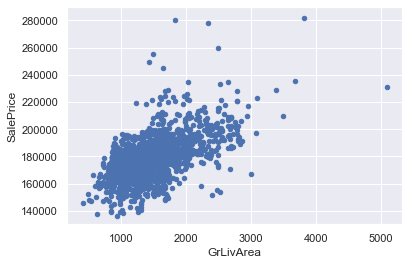

In [27]:
# bivariate analysis saleprice/grlivarea
var = 'GrLivArea'

data = pd.concat([house_prices['SalePrice'], full_dataset[var]], axis=1)

data.plot.scatter(x=var, y='SalePrice', ylim=(130000,290000));

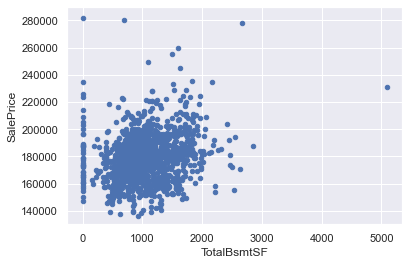

In [28]:
# bivariate analysis saleprice/grlivarea
# GrLivArea: Above grade (ground) living area square feet
var = 'TotalBsmtSF'

data = pd.concat([house_prices['SalePrice'], full_dataset[var]], axis=1)

data.plot.scatter(x=var, y='SalePrice', ylim=(130000,290000));

In [29]:
# Finding value that being the otlier by Square Feet.
data.sort_values(by='TotalBsmtSF', ascending=False)[:1]

,SalePrice,TotalBsmtSF
1089,230841,5095.0


In [30]:
# Finding values that being the otliers by Sale Price.
data.sort_values(by='SalePrice', ascending=False)[:3]

,SalePrice,TotalBsmtSF
728,281643,0.0
790,280618,686.0
803,277936,2660.0


In [31]:
# Making the `DropList`.
to_drop_list = [728, 790, 803, 1089]

In [32]:
# removing outliers.
for i in to_drop_list:
    data = data.drop(data[data.index == i].index)

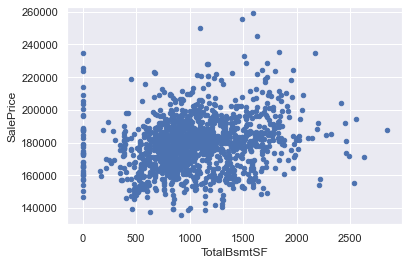

In [33]:
# Checking the new result.
data.plot.scatter(x=var, y='SalePrice', ylim=(130000,263000));

The point here is to test 'SalePrice' in a very lean way. We'll do this paying attention to:

***Histogram*** - Kurtosis and skewness.  
***Normal probability plot*** - Data distribution should closely follow the diagonal that represents the normal distribution.

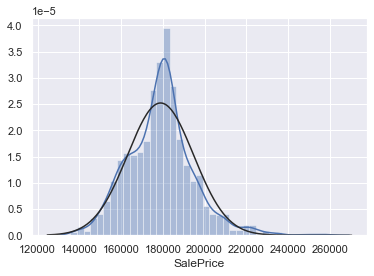

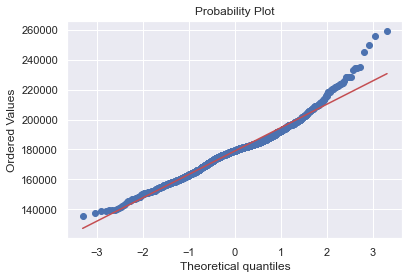

In [34]:
# histogram and normal probability plot
sns.distplot(data['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(data['SalePrice'], plot=plt)

#### A simple data transformation 

In [35]:
# applying log transformation
data['SalePrice'] = np.log(data['SalePrice'])

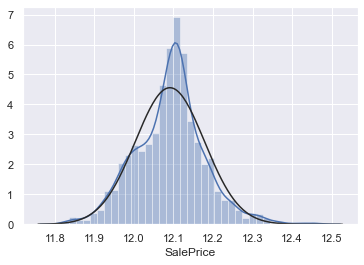

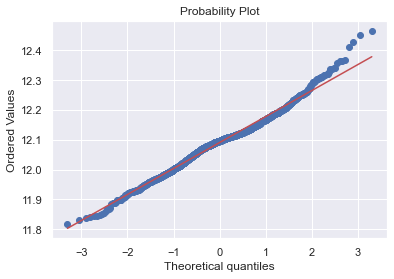

In [36]:
# transformed histogram and normal probability plot
sns.distplot(data['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(data['SalePrice'], plot=plt)

**Have appreciable positive skewness.**